In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import argparse
import string
import os.path as osp
import operator
# non-standard dependencies:
import numpy as np
from scipy.misc import imread, imresize

In [2]:
vg_path='../data/visual_genome/'
"""
Our vocabulary will add __background__, COCO categories, <UNK>, PAD, BOS, EOS
"""
# remove bad words, and return final sentences (sent_id -> final)
# count up the number of words
#   count_thr = params['word_count_threshold']

with open(osp.join(vg_path,'scene_graphs_pp.json'), 'r') as f:
    images = json.load(f)
print('sgpp loaded')
with open(osp.join(vg_path, 'image_data_split1000.json'), 'r') as f:
    imgs_info = json.load(f)
    info_dict = {img['image_id']: img for img in imgs_info}

Images = dict()
for img in images:
    info = info_dict[img['image_id']]
    if info['split'] in ['train', 'val']:    
        Images[img['image_id']] = img

sgpp loaded


In [3]:
special = []
def replace_special(name):
    name = name.lower()
    i = 0
    while i < len(name):
        c = name[i]
        if (c > 'z' or c < 'a') and c != ' ':
            if c not in special: 
                special.append(c)
            name = name[:i] + ' ' + c + ' ' + name[i+1:]
            i += 2
#             print(name)
        i += 1
    return name


def count_words_vg(source='names', Images = Images):
    word2count = {}
    for id, img in Images.items():
        if source in ['names', 'attributes']:
            for obj in img['objects']:
                if source in obj:
                    for string in obj[source]:
                        string = replace_special(string)
                        for wd in string.split():
                            word2count[wd] = word2count.get(wd, 0) + 1
        elif source == 'relationships':
            for rel in img['relationships']:
                string = rel['predicate']
                string = replace_special(string)
                for wd in string.split():
                    word2count[wd] = word2count.get(wd, 0) + 1
        else:
            raise NotImplementedError
    return word2count

def merge_count(count1, count2):
    if len(count1) < len(count2):
        count3 = count1
        count1 = count2
        count2 = count3
    count = dict(count1)
    for w,c in count2.items():
        count[w] = count.get(w, 0) + count2[w]
    return count

def add_count(count1, count2):
    for w, c in count2.items():
        count1[w] = count1.get(w, 0) + count2[w]
    return count1

def build_vocab(word2count, count_thr):
    total_count = sum(word2count.values())
    bad_words = [wd for wd, n in word2count.items() if n <= count_thr]
    bad_count = sum([word2count[wd] for wd in bad_words])
    
    good_words_freq= [i for i in word2count.items() if i[1] > count_thr]
    good_words_freq = sorted(good_words_freq, key=lambda x: -x[1])
    good_words = [x[0] for x in good_words_freq]
    good_freq = [x[1] for x in good_words_freq]
    print(good_words_freq[:10])
    print(good_words[:10])
    print(good_freq[:10])
    print('number of good words: %d' % len(good_words))
    print('number of bad words: %d/%d = %.2f%%' 
          % (len(bad_words), len(word2count), len(bad_words)*100.0/len(word2count)))
    print('number of UNKs in sentences: %d/%d = %.2f%%' 
          % (bad_count, total_count, bad_count*100.0/total_count))

    # add UNK, BOS, EOS, PAD
    vocab = ['<PAD>', '<UNK>', '<BOS>', '<EOS>'] + good_words
    freq = [good_freq[0] * 10] * 4 + good_freq
    return vocab, freq

def build_lookup(included, count_thresh, vg_count=None, rc_count=None, fast_text_path='../data/fast_text/'):
    lookup = {}
    lookup['included'] = included
    count = {}
    if 'vg_names' in included:
        count = add_count(count, vg_count['names'])
    if 'vg_attributes' in included:
        count = add_count(count, vg_count['attributes'])
    if 'vg_relationships' in included:
        count = add_count(count, vg_count['relationships'])
        
    if 'refcoco' in included:
        count = add_count(count, rc_count['refcoco'])
    if 'refcoco+' in included:
        count = add_count(count, rc_count['refcoco+'])
    if 'refcocog' in included:
        count = add_count(count, rc_count['refcocog'])
    
    vocab, freq = build_vocab(count, count_thresh)
    lookup['ix_to_word'] = vocab
    lookup['freq'] = freq
    ft_vocab = np.load(osp.join(fast_text_path, 'vocabulary_ft.npy'))
    ft_vocab = list(ft_vocab)
    ft_embeddings = np.load(osp.join(fast_text_path, 'embeddings_ft.npy'))
    
    embeddings = np.empty((len(vocab), 300))
    for i, w in enumerate(vocab):
        if w in ft_vocab:
            ft_i = ft_vocab.index(w)
            embeddings[i] = ft_embeddings[ft_i]
        else:
            embeddings[i] = np.random.randn(300) / 300.0
            print(i, w, freq[i])
    lookup['embeddings'] = embeddings
    return lookup

In [4]:
vg_name_count = count_words_vg('names')  # full vg: len 26160  sgpp 25972
vg_att_count = count_words_vg('attributes')  # full vg: len 20284 sgpp 20196
vg_rel_count = count_words_vg('relationships')  # full vg: len 7973 sgpp 7940

In [5]:
print(len(vg_name_count))
print(len(vg_att_count))
print(len(vg_rel_count))

25972
20196
7940


In [6]:
import matplotlib.pyplot as plt

def plot_count(word2count):
    count = word2count.values()
    count.sort()
    plt.plot(count)
    return

<IPython.core.display.Javascript object>


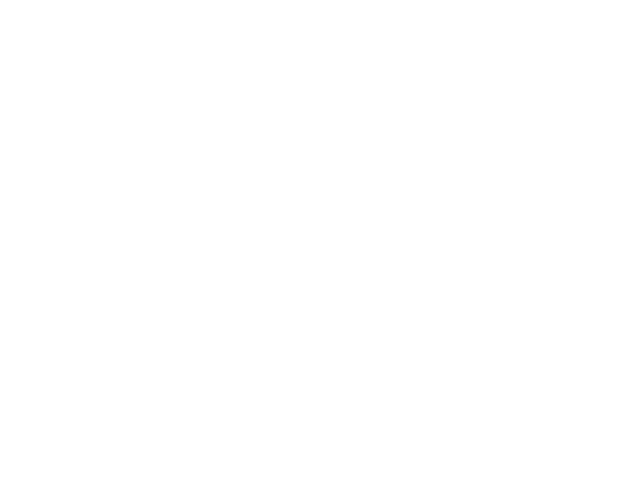

25972 20196 7940
35282
36973


In [7]:
%matplotlib notebook
plot_count(vg_name_count)
plot_count(vg_att_count)
plot_count(vg_rel_count)

print(len(vg_name_count), len(vg_att_count), len(vg_rel_count))

name_att_count = merge_count(vg_name_count, vg_att_count)
print(len(name_att_count))
vg_count = merge_count(name_att_count, vg_rel_count)
print(len(vg_count))

plot_count(name_att_count)
plot_count(vg_count)

In [8]:
thresh = 10
print('name')
name_vocab, _ = build_vocab(vg_name_count, thresh)
print('\natt')
att_vocab, _ = build_vocab(vg_att_count, thresh)
print('\nrel')
rel_vocab, _ = build_vocab(vg_rel_count, thresh)
print('\nname_att')
name_att_vocab = build_vocab(name_att_count, thresh)
print('\nvg')
vg_vocab, _ = build_vocab(vg_count, thresh)

name
[(u'man', 97600), (u'window', 73367), (u'person', 71980), (u'tree', 56338), (u'shirt', 55658), (u'building', 49413), (u'sign', 48998), (u'wall', 48109), (u'woman', 43938), (u'sky', 43118)]
[u'man', u'window', u'person', u'tree', u'shirt', u'building', u'sign', u'wall', u'woman', u'sky']
[97600, 73367, 71980, 56338, 55658, 49413, 48998, 48109, 43938, 43118]
number of good words: 5725
number of bad words: 20247/25972 = 77.96%
number of UNKs in sentences: 45486/4157286 = 1.09%

att
[(u'white', 314890), (u'black', 199195), (u'blue', 126013), (u'green', 120681), (u'red', 111687), (u'brown', 100185), (u'yellow', 63232), (u'small', 45329), (u'large', 44655), (u'gray', 33742)]
[u'white', u'black', u'blue', u'green', u'red', u'brown', u'yellow', u'small', u'large', u'gray']
[314890, 199195, 126013, 120681, 111687, 100185, 63232, 45329, 44655, 33742]
number of good words: 4631
number of bad words: 15565/20196 = 77.07%
number of UNKs in sentences: 36908/2669466 = 1.38%

rel
[(u'on', 846610),

In [9]:
vg_counts = {'names': vg_name_count,
            'attributes': vg_att_count,
            'relationships': vg_rel_count}

vg_lookup = build_lookup(['vg_names', 'vg_attributes', 'vg_relationships'], 10, vg_counts)

# np.save('../data/fast_text/wordcounts_vgpp_trainval.npy', vg_counts)
np.save('../data/fast_text/lookup_vgpp_trainval.npy', vg_lookup)

[(u'on', 860049), (u'white', 320908), (u'in', 314642), (u'has', 275548), (u'of', 257163), (u'black', 203469), (u'wearing', 140735), (u'blue', 129016), (u'a', 126446), (u'green', 123135)]
[u'on', u'white', u'in', u'has', u'of', u'black', u'wearing', u'blue', u'a', u'green']
[860049, 320908, 314642, 275548, 257163, 203469, 140735, 129016, 126446, 123135]
number of good words: 8654
number of bad words: 28319/36973 = 76.59%
number of UNKs in sentences: 64562/9752126 = 0.66%
0 <PAD> 8600490
1 <UNK> 8600490
2 <BOS> 8600490
3 <EOS> 8600490
2415 whtie 178
2805 kneepad 133
3266 silvertone 98
3507 snowpants 84
3518 leaveless 83
3738 lightpost 73
3784 surboard 71
3876 badsentence 68
3923 surfboarder 66
3967 wildebeast 65
3984 woode 64
3991 windsheild 64
4058 hoove 62
4173 numberal 58
4357 traincar 53
4474 surfboarding 50
4607 turqoise 47
4612 sitted 47
4628 ellow 47
4654 _ 46
4661 ripply 46
4712 lightpole 45
4726 giraffee 44
4772 trafficlight 43
4812 sandle 43
4817 squirr 43
4931 ` 40
4956 winshi

In [10]:
refer_dir = osp.join('..', 'pyutils', 'refer')
sys.path.insert(0, refer_dir)
from refer import REFER

def count_words_refcocox(data_root = '../data', dataset='refcoco', splitBy='unc'):
    refer = REFER(data_root, dataset, splitBy)
    sentToTokens = refer.sentToTokens
    # count the number of words
    word2count = {}
    for sent_id, tokens in sentToTokens.items():
        for string in tokens:
            string = replace_special(string)
            for wd in string.split():
                word2count[wd] = word2count.get(wd, 0) + 1
    
    # add category words
    category_names = refer.Cats.values() + ['__background__']
    for cat_name in category_names:
        for wd in cat_name.split():
                word2count[wd] = 1e5
    return word2count

rc_count = count_words_refcocox(dataset='refcoco')
rcp_count = count_words_refcocox(dataset='refcoco+')
rcg_count = count_words_refcocox(dataset='refcocog', splitBy='google')

print(len(rc_count), len(rcp_count), len(rcg_count))


loading dataset refcoco into memory...
creating index...
index created.
DONE (t=13.88s)
loading dataset refcoco+ into memory...
creating index...
index created.
DONE (t=8.22s)
loading dataset refcocog into memory...
creating index...
index created.
DONE (t=8.01s)
10127 11773 12324


<IPython.core.display.Javascript object>


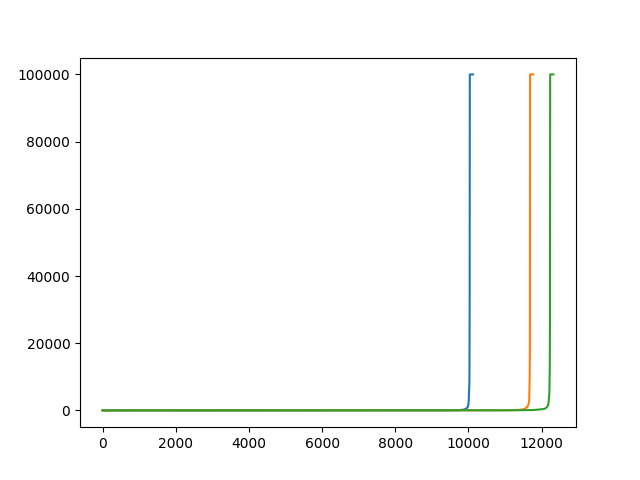

In [11]:
%matplotlib notebook
plot_count(rc_count)
plot_count(rcp_count)
plot_count(rcg_count)

In [12]:
thresh = 10
print('rc')
rc_vocab, _ = build_vocab(rc_count, thresh)
print('\nrc+')
rcp_vocab, _ = build_vocab(rcp_count, thresh)
print('\nrcg')
rcg_vocab, _ = build_vocab(rcg_count, thresh)
print('\nvg_rc')
vg_rc_count = merge_count(vg_count, rc_count)
vg_rc_vocab, _ = build_vocab(vg_rc_count, thresh)
print('\nvg_rc+')
vg_rcp_count = merge_count(vg_count, rcp_count)
vg_rcp_vocab, _ = build_vocab(vg_rcp_count, thresh)
print('\nvg_rcg')
vg_rcg_count = merge_count(vg_count, rcg_count)
vg_rcg_vocab, _ = build_vocab(vg_rcg_count, thresh)
print('\nvg_rc_rc+')
vg_rc_rcp_count = merge_count(vg_rc_count, rcp_count)
vg_rc_rcp_vocab, _ = build_vocab(vg_rc_rcp_count, thresh)
print('\nvg_rcall')
vg_rcall_count = merge_count(vg_rc_rcp_count, rcg_count)
vg_rcall_vocab, _ = build_vocab(vg_rcall_count, thresh)


rc
[('glass', 100000.0), ('hot', 100000.0), ('wine', 100000.0), ('backpack', 100000.0), ('__background__', 100000.0), ('person', 100000.0), ('toaster', 100000.0), ('chair', 100000.0), ('sign', 100000.0), ('elephant', 100000.0)]
['glass', 'hot', 'wine', 'backpack', '__background__', 'person', 'toaster', 'chair', 'sign', 'elephant']
[100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0]
number of good words: 1367
number of bad words: 8760/10127 = 86.50%
number of UNKs in sentences: 17282/9735602 = 0.18%

rc+
[('glass', 100000.0), ('hot', 100000.0), ('wine', 100000.0), ('backpack', 100000.0), ('__background__', 100000.0), ('toaster', 100000.0), ('chair', 100000.0), ('sign', 100000.0), ('elephant', 100000.0), ('truck', 100000.0)]
['glass', 'hot', 'wine', 'backpack', '__background__', 'toaster', 'chair', 'sign', 'elephant', 'truck']
[100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0]
number of goo

In [13]:
# 'rca' means ['refcoco', 'refcoco+', 'refcocog']
rca_counts = {'refcoco': rc_count,
              'refcoco+': rcp_count,
              'refcocog': rcg_count}

rca_lookup = build_lookup(['refcoco', 'refcoco+', 'refcocog'], 10, rc_count=rca_counts)

# np.save('../data/fast_text/wordcounts_rca.npy', rca_counts)
np.save('../data/fast_text/lookup_rca.npy', rca_lookup)

vg_rca_lookup = build_lookup(['vg_names', 'vg_attributes', 'vg_relationships', 'refcoco', 'refcoco+', 'refcocog'],
                             10, vg_counts, rca_counts)

np.save('../data/fast_text/lookup_vgpp_tv_rca.npy', vg_rca_lookup)



[('chair', 300000.0), ('traffic', 300000.0), ('clock', 300000.0), ('horse', 300000.0), ('microwave', 300000.0), ('knife', 300000.0), ('couch', 300000.0), ('cup', 300000.0), ('skateboard', 300000.0), ('racket', 300000.0)]
['chair', 'traffic', 'clock', 'horse', 'microwave', 'knife', 'couch', 'cup', 'skateboard', 'racket']
[300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0]
number of good words: 3546
number of bad words: 18421/21967 = 83.86%
number of UNKs in sentences: 39042/29497545 = 0.13%
0 <PAD> 3000000.0
1 <UNK> 3000000.0
2 <BOS> 3000000.0
3 <EOS> 3000000.0
17 __background__ 300000.0
718 brocoli 178
840 girafe 139
970 giraffee 108
1153 girafee 78
1165 zbra 76
1203 giraff 72
1260 frt 67
1312 girrafe 64
1359 fartest 60
1535 broccolli 48
1548 broccli 47
1719 faceing 39
1749 tabule 37
1849 cloest 34
1875 shrit 33
1879 ocklock 33
1925 sanwich 32
2034 girraff 29
2116 girraffe 27
2174 motercycle 26
2230 rightiest 24
2273 smilling 24
2288 bot

In [14]:
lookup = np.load('../data/fast_text/lookup_vgpp_tv_rca.npy')
lookup.item()

{'embeddings': array([[-9.24265296e-04,  2.95126215e-03,  2.37172635e-04, ...,
          2.25481651e-03,  6.62100336e-04,  1.30300098e-05],
        [-2.87650209e-04,  2.65743216e-03,  5.38705415e-03, ...,
         -8.37576326e-04,  9.50372863e-03, -3.73860302e-03],
        [-5.78585125e-03,  6.90829237e-05,  1.25323283e-03, ...,
         -6.25259214e-04,  2.97622009e-03, -4.87447596e-03],
        ...,
        [ 2.31000000e-01,  1.21200000e-01, -1.83400000e-01, ...,
         -7.13000000e-02,  1.67400000e-01,  9.48000000e-02],
        [-1.40100000e-01, -7.00000000e-03, -1.15500000e-01, ...,
          8.73000000e-02, -3.41000000e-02,  6.50000000e-03],
        [-1.02800000e-01,  6.05000000e-02,  4.47000000e-02, ...,
          2.36000000e-02, -7.99000000e-02, -4.20000000e-03]]),
 'freq': [9149850,
  9149850,
  9149850,
  9149850,
  914985,
  379680,
  373199.0,
  354306.0,
  352704,
  350356.0,
  335271.0,
  334209.0,
  330960.0,
  327564.0,
  324728.0,
  324291.0,
  318582.0,
  315575.0,
 

In [3]:
refer_dir = osp.join('..', 'pyutils', 'refer')
sys.path.insert(0, refer_dir)
from refer import REFER

refer = REFER(data_root='../data', dataset='refcoco', splitBy='unc')
category_names = refer.Cats.values()
print(category_names)

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=14.25s)
[u'person', u'bicycle', u'car', u'motorcycle', u'airplane', u'bus', u'train', u'truck', u'boat', u'traffic light', u'fire hydrant', u'stop sign', u'parking meter', u'bench', u'bird', u'cat', u'dog', u'horse', u'sheep', u'cow', u'elephant', u'bear', u'zebra', u'giraffe', u'backpack', u'umbrella', u'handbag', u'tie', u'suitcase', u'frisbee', u'skis', u'snowboard', u'sports ball', u'kite', u'baseball bat', u'baseball glove', u'skateboard', u'surfboard', u'tennis racket', u'bottle', u'wine glass', u'cup', u'fork', u'knife', u'spoon', u'bowl', u'banana', u'apple', u'sandwich', u'orange', u'broccoli', u'carrot', u'hot dog', u'pizza', u'donut', u'cake', u'chair', u'couch', u'potted plant', u'bed', u'dining table', u'toilet', u'tv', u'laptop', u'mouse', u'remote', u'keyboard', u'cell phone', u'microwave', u'oven', u'toaster', u'sink', u'refrigerator', u'book', u'clock', u'vase', u'scissors', u'teddy bear', 

NameError: name 'count_info' is not defined

In [5]:
with open('../data/visual_genome/name_att_rel_count_pp.json', 'r') as f:
    count_info = json.load(f)


In [11]:
c = sorted(count_info['name'].items(), key=lambda x: -x[1])
print(c[:100])


[(u'man', 96218), (u'person', 71049), (u'window', 70758), (u'shirt', 51604), (u'tree', 50913), (u'building', 48690), (u'wall', 46783), (u'sky', 42933), (u'woman', 42501), (u'sign', 42439), (u'ground', 39749), (u'grass', 34734), (u'table', 30069), (u'pole', 29934), (u'head', 28382), (u'light', 28290), (u'car', 27531), (u'water', 27085), (u'hair', 26171), (u'hand', 25471), (u'people', 22629), (u'leg', 22405), (u'clouds', 22192), (u'trees', 22068), (u'plate', 19202), (u'leaves', 18956), (u'ear', 18436), (u'pants', 18204), (u'fence', 17539), (u'door', 17419), (u'chair', 16747), (u'eye', 16697), (u'hat', 16567), (u'floor', 16566), (u'train', 16444), (u'road', 16162), (u'jacket', 15641), (u'street', 15605), (u'snow', 15593), (u'wheel', 15037), (u'line', 14789), (u'shadow', 14450), (u'boy', 13799), (u'nose', 13656), (u'shoe', 13287), (u'letter', 12962), (u'cloud', 12947), (u'clock', 12919), (u'boat', 12886), (u'tail', 12828), (u'handle', 12781), (u'sidewalk', 12761), (u'field', 12389), (u'gir

In [15]:
print([i[1] for i in c[:500]])

[96218, 71049, 70758, 51604, 50913, 48690, 46783, 42933, 42501, 42439, 39749, 34734, 30069, 29934, 28382, 28290, 27531, 27085, 26171, 25471, 22629, 22405, 22192, 22068, 19202, 18956, 18436, 18204, 17539, 17419, 16747, 16697, 16567, 16566, 16444, 16162, 15641, 15605, 15593, 15037, 14789, 14450, 13799, 13656, 13287, 12962, 12947, 12919, 12886, 12828, 12781, 12761, 12389, 12305, 12163, 12008, 11982, 11972, 11918, 11898, 11797, 11719, 11653, 11626, 11509, 11259, 11014, 10973, 10961, 10788, 10776, 10511, 10366, 10215, 10136, 9714, 9611, 9514, 9493, 9373, 9270, 9117, 9101, 9015, 8594, 8499, 8454, 8392, 8294, 8290, 8255, 8208, 8193, 8152, 8147, 8067, 8057, 8019, 7941, 7914, 7840, 7698, 7695, 7678, 7592, 7558, 7446, 7415, 7318, 7234, 7234, 7220, 7079, 7075, 7001, 6996, 6951, 6931, 6797, 6739, 6734, 6607, 6408, 6303, 6284, 6268, 6237, 6231, 6218, 6193, 6173, 6157, 6110, 6066, 6021, 5948, 5904, 5904, 5842, 5802, 5722, 5717, 5560, 5517, 5462, 5403, 5372, 5320, 5311, 5308, 5179, 5175, 5073, 5066, 